In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Set the random seed for reproducibility

from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [3]:
file_path = Path("aapl.csv")
aapl_df = pd.read_csv(file_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
aapl_df.dropna(inplace=True)
aapl_df.sort_index(inplace=True)
df = aapl_df.iloc[-1512:]
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-04-11,27.2425,27.6525,27.2075,27.2550,117630072
2016-04-12,27.3350,27.6250,27.1650,27.6100,108929300
2016-04-13,27.7000,28.0850,27.7000,28.0100,133029264
2016-04-14,27.9050,28.0975,27.8325,28.0250,101895692
2016-04-15,28.0275,28.0750,27.4325,27.4625,187755876


In [4]:
def window_data(aapl_df, window, feature_col_number, target_col_number):
    
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1) 

In [5]:
window_size = 5

feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[27.255  27.61   28.01   28.025  27.4625]
 [27.61   28.01   28.025  27.4625 26.87  ]
 [28.01   28.025  27.4625 26.87   26.7275]
 [28.025  27.4625 26.87   26.7275 26.7825]
 [27.4625 26.87   26.7275 26.7825 26.4925]] 

y sample values:
[[26.87  ]
 [26.7275]
 [26.7825]
 [26.4925]
 [26.42  ]]


In [6]:
test_size = 30
simulation_size = 10

df_train = df.iloc[:-test_size]
df_test = df.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1512, 5), (1482, 5), (30, 5))

In [7]:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [8]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.07116193]
  [0.07657146]
  [0.0826667 ]
  [0.08289527]
  [0.07265482]]

 [[0.07657146]
  [0.0826667 ]
  [0.08289527]
  [0.07432384]
  [0.06382899]]

 [[0.0826667 ]
  [0.08289527]
  [0.07432384]
  [0.06529526]
  [0.06170633]]

 [[0.08289527]
  [0.07432384]
  [0.06529526]
  [0.06312383]
  [0.0625256 ]]

 [[0.07432384]
  [0.06529526]
  [0.06312383]
  [0.06396193]
  [0.05820579]]] 

X_test sample values:
[[[0.99523809]
  [0.99577181]
  [0.98811466]
  [1.02297182]
  [1.0285253 ]]

 [[0.99577181]
  [0.98811466]
  [1.02297182]
  [1.0521524 ]
  [1.00443153]]

 [[0.98811466]
  [1.02297182]
  [1.0521524 ]
  [1.02750515]
  [1.02223178]]

 [[1.02297182]
  [1.0521524 ]
  [1.02750515]
  [1.0457143 ]
  [0.98048635]]

 [[1.0521524 ]
  [1.02750515]
  [1.0457143 ]
  [1.00300991]
  [1.01083641]]]


In [10]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [11]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [12]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [13]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             3840      
                                                                 
 dropout (Dropout)           (None, 5, 30)             0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 30)             0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [21]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=90, verbose=1)

Train on 1054 samples
Epoch 1/100
1054/1054 [==============================] - 1s 597us/sample - loss: 0.0375
Epoch 2/100
1054/1054 [==============================] - 0s 269us/sample - loss: 0.0178
Epoch 3/100
1054/1054 [==============================] - 0s 276us/sample - loss: 0.0122
Epoch 4/100
1054/1054 [==============================] - 0s 282us/sample - loss: 0.0078
Epoch 5/100
1054/1054 [==============================] - 0s 284us/sample - loss: 0.0063
Epoch 6/100
1054/1054 [==============================] - 0s 276us/sample - loss: 0.0049
Epoch 7/100
1054/1054 [==============================] - 0s 270us/sample - loss: 0.0039
Epoch 8/100
1054/1054 [==============================] - 0s 280us/sample - loss: 0.0033
Epoch 9/100
1054/1054 [==============================] - 0s 282us/sample - loss: 0.0026
Epoch 10/100
1054/1054 [==============================] - 0s 286us/sample - loss: 0.0025
Epoch 11/100
1054/1054 [==============================] - 0s 279us/sample - loss: 0.0023
Epoch 12

In [22]:
# Evaluate the model
model.evaluate(X_test, y_test)

0.2718605970178482

In [23]:
# Make some predictions
predicted = model.predict(X_test)

In [24]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
aapl_stock = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
aapl_stock.head()

,Real,Predicted
Date,,
2020-06-24,90.015000,85.108238
2020-06-25,91.209975,85.522545
2020-06-26,88.407500,86.014931
2020-06-29,90.444975,86.486435
2020-06-30,91.200000,86.524704


<AxesSubplot:xlabel='Date'>

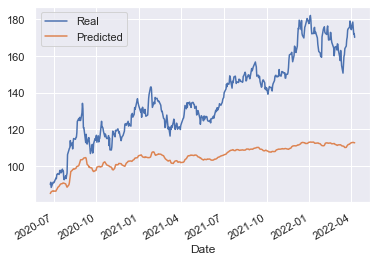

In [26]:
aapl_stock.plot()

In [27]:
aapl_stock.tail()

,Real,Predicted
Date,,
2022-04-04,178.4400,112.860107
2022-04-05,175.0600,112.919601
2022-04-06,171.8300,112.812233
2022-04-07,172.1399,112.707611
2022-04-08,170.0900,112.727943
